In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow

# Libraries

In [ ]:
import tensorflow as tf  #building and training machine learning models
from tensorflow.keras import layers, models #building blocks and neural network models(sequential)
import numpy as np #numerical arrays and matrices
from pathlib import Path # handeling file pathes
from PIL import Image #for handlig imeges
import matplotlib.pyplot as plt #create visualization
from tensorflow.keras.applications import DenseNet121 #pre-trained DenseNet121 model
from tensorflow.keras.preprocessing.image import ImageDataGenerator# tool for data augmentation and preprocessing
#------------------------------------------------------------------------------------------

# Preprocess Dataset

In [ ]:
# Set image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Function to load and preprocess the image
def load_image(file_path):
    file_path = file_path.decode("utf-8")  # Decode TensorFlow byte string to Python string
    img = Image.open(file_path).convert("RGB")  # Convert image to RGB
    img = img.resize((img_width, img_height))  # Resize to target shape
    img_array = np.array(img, dtype=np.float32)  # Convert to NumPy array
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array


# Function to wrap the image loading into TensorFlow's pipeline
def tf_load_image(file_path, label):
    img_array = tf.numpy_function(load_image, [file_path], tf.float32)
    img_array.set_shape((img_height, img_width, 3))  # Set fixed shape
    return img_array, label



# Load Pathes of Dataset

In [ ]:
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Copy Dataset from Google Drive to Local Environment
drive_train_dir = '/content/drive/MyDrive/new_dataset/train'
drive_val_dir = '/content/drive/MyDrive/new_dataset/validation'
drive_test_dir = '/content/drive/MyDrive/new_dataset/test'

# Local paths in Colab
local_train_dir = '/content/augmented_train'
local_val_dir = '/content/validation'
local_test_dir = '/content/test'

# Copy datasets to local environment
shutil.copytree(drive_train_dir, local_train_dir, dirs_exist_ok=True)
shutil.copytree(drive_val_dir, local_val_dir, dirs_exist_ok=True)
shutil.copytree(drive_test_dir, local_test_dir, dirs_exist_ok=True)
print("Datasets copied to Colab environment.")

Datasets copied to Colab environment.


In [ ]:
# Define paths to your directories
train_dir = drive_train_dir
val_dir =drive_val_dir
test_dir = drive_test_dir

# Function to handel .tif imeges

In [ ]:
train_dir = Path(train_dir)

# Get the class names by listing directories
class_names = sorted([folder.name for folder in train_dir.iterdir() if folder.is_dir()])
num_classes = len(class_names)
print(f"Class Names: {class_names}")

Class Names: ['Adenovirus', 'Astrovirus', 'CCHF', 'Cowpox', 'Ebola', 'Influenza', 'Lassa', 'Marburg', 'Nipah virus', 'Norovirus', 'Orf', 'Papilloma', 'Rift Valley', 'Rotavirus']


In [ ]:
# Create a function to prepare datasets
def prepare_dataset(directory, class_names, batch_size):
    # Convert directory to Path object if it's a string
    directory = Path(directory) if isinstance(directory, str) else directory

    # Get paths to all .tif files
    file_paths = list(directory.rglob("*.tif"))
    labels = [path.parent.name for path in file_paths]  # Folder names as labels
    label_to_index = {label: i for i, label in enumerate(class_names)}  # Map class name
    # Filter labels and file paths to include only valid classes
    valid_file_paths = []
    valid_labels = []

    for file_path, label in zip(file_paths, labels):
        if label in label_to_index:
            valid_file_paths.append(str(file_path))
            valid_labels.append(label_to_index[label])
        else:
            print(f"Skipping file with unknown label: {label} ({file_path})")
  # Create TensorFlow dataset from valid file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((valid_file_paths, valid_labels))

    # Apply image loading function and batch the dataset
    dataset = dataset.map(
        lambda x, y: tf_load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Prepare datasets
train_ds = prepare_dataset(train_dir, class_names, batch_size)
val_ds = prepare_dataset(val_dir, class_names, batch_size)
test_ds = prepare_dataset(test_dir, class_names, batch_size)

# Training,Testing and val

In [ ]:
#For training
train_datagen =  ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    #target_size=(224, 224),  # Resize images to 224x224
     target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Adjust this based on your problem (binary/categorical), labels are one-hot encoded for multi-class classification.

)
# For validation
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
   # target_size=(224, 224),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
#For testing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Correct path to your test directory
    #target_size=(224, 224),  # Resize images to 224x224
 target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False

)

Found 10109 images belonging to 14 classes.
Found 2891 images belonging to 14 classes.
Found 1453 images belonging to 14 classes.


# **Model Denesnet121**

In [ ]:

# Define the base model explicitly
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model initially (for feature extraction training)
base_model.trainable = False

#un freez last 20 layer
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add the classification head to the base model
model = tf.keras.Sequential([
    base_model,  # Base pre-trained model
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),#Adds a fully connected layer
    layers.Dropout(0.5), #randomly deactivating 50% of neurons during training(to reduce overfitting)
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

# Display model summary
model.summary() #Prints the architecture of the model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 14)                  │          14,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,101,454 (30.90 MB)

 Trainable params: 1,431,118 (5.46 MB)

 Non-trainable params: 6,670,336 (25.45 MB)

# Compile,train and summery Model

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',                # Choose an optimizer
    loss='categorical_crossentropy',  # Specify a loss function
    metrics=['accuracy']             # Specify metrics to monitor
)
print(f"model compile successfly")

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10)


model compile successfly
Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 112s 274ms/step - accuracy: 0.6437 - loss: 1.1263 - val_accuracy: 0.9132 - val_loss: 0.2590
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 118s 229ms/step - accuracy: 0.9092 - loss: 0.2667 - val_accuracy: 0.9433 - val_loss: 0.1693
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 69s 215ms/step - accuracy: 0.9426 - loss: 0.1704 - val_accuracy: 0.9533 - val_loss: 0.1270
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 72s 226ms/step - accuracy: 0.9589 - loss: 0.1160 - val_accuracy: 0.9564 - val_loss: 0.1445
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 74s 231ms/step - accuracy: 0.9620 - loss: 0.1114 - val_accuracy: 0.9609 - val_loss: 0.1247
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 75s 235ms/step - accuracy: 0.9716 - loss: 0.0873 - val_accuracy: 0.9495 - val_loss: 0.1780
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 68s 211ms/step - accuracy: 0.9682 - loss: 0.0956 - val_accuracy: 0.9412 - val_loss: 0.2398
Epoch 8/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 68s 212ms/step -

# Accuracy

In [ ]:
#  evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9563 - loss: 0.1872
Test accuracy: 95.73%


In [ ]:
# evaluate model
val_loss , val_accuracy = model.evaluate(val_generator)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.9716 - loss: 0.1271
Validation accuracy: 97.13%


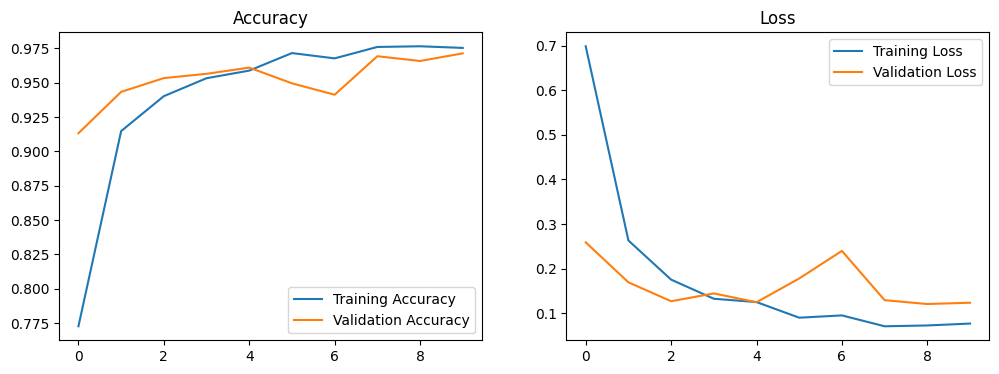

In [ ]:
#visualize training result
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


# **Generate prediction**

In [ ]:
# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/my_denes.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 23 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Get predictions
y_pred_probs = model.predict(test_generator)  # Probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)      # Predicted class indices
# Get true labels
y_true = test_generator.classes  # True class indices
class_labels = list(test_generator.class_indices.keys())  # Class names

 1/46 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step


**Confusion Matrix**

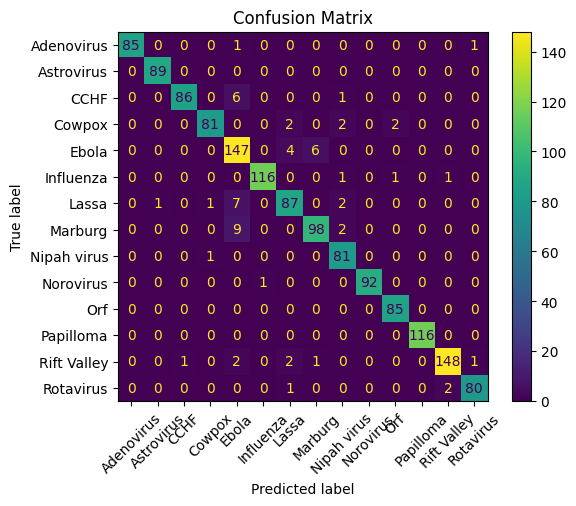

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

**Precision, Recall, F1-Score**

In [ ]:
from sklearn.metrics import classification_report
# @title report(recall,f1-score,precision)
# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

  Adenovirus     1.0000    0.9770    0.9884        87
  Astrovirus     0.9889    1.0000    0.9944        89
        CCHF     0.9885    0.9247    0.9556        93
      Cowpox     0.9759    0.9310    0.9529        87
       Ebola     0.8547    0.9363    0.8936       157
   Influenza     0.9915    0.9748    0.9831       119
       Lassa     0.9062    0.8878    0.8969        98
     Marburg     0.9333    0.8991    0.9159       109
 Nipah virus     0.9101    0.9878    0.9474        82
   Norovirus     1.0000    0.9892    0.9946        93
         Orf     0.9659    1.0000    0.9827        85
   Papilloma     1.0000    1.0000    1.0000       116
 Rift Valley     0.9801    0.9548    0.9673       155
   Rotavirus     0.9756    0.9639    0.9697        83

    accuracy                         0.9573      1453
   macro avg     0.9622    0.9590    0.9602      1453
weighted avg     0.9588    0.9573    0.9576      1453



/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step
F1 Score: 0.9714


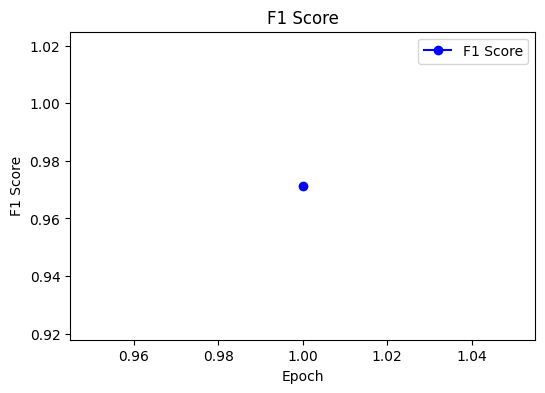

In [ ]:
from sklearn.metrics import f1_score
# @title f1 score graph
# Make predictions on the validation set
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the validation generator
true_labels = val_generator.classes

# Calculate F1 score
f1 = f1_score(true_labels, predicted_classes, average='weighted')

# Print the F1 score
print(f"F1 Score: {f1:.4f}")

# If you want to plot the F1 score (for a single epoch, it's just a single value)
# Plotting F1 score (for the sake of visualization, we plot it as a single point here)
plt.figure(figsize=(6, 4))
plt.plot([1], [f1], 'bo-', label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

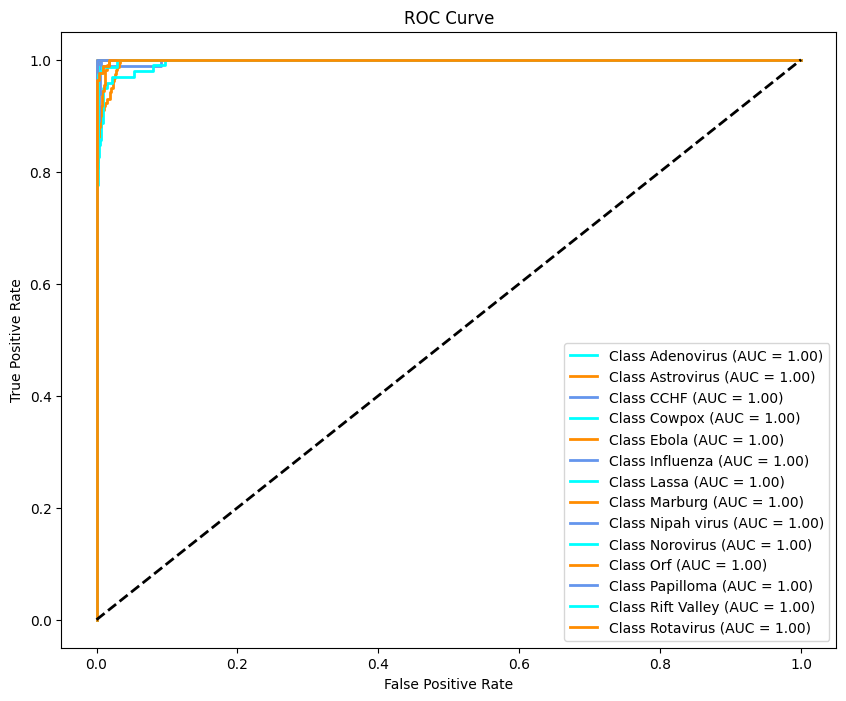

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
# @title ROC and AUC
# Binarize true labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=np.arange(len(class_labels)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


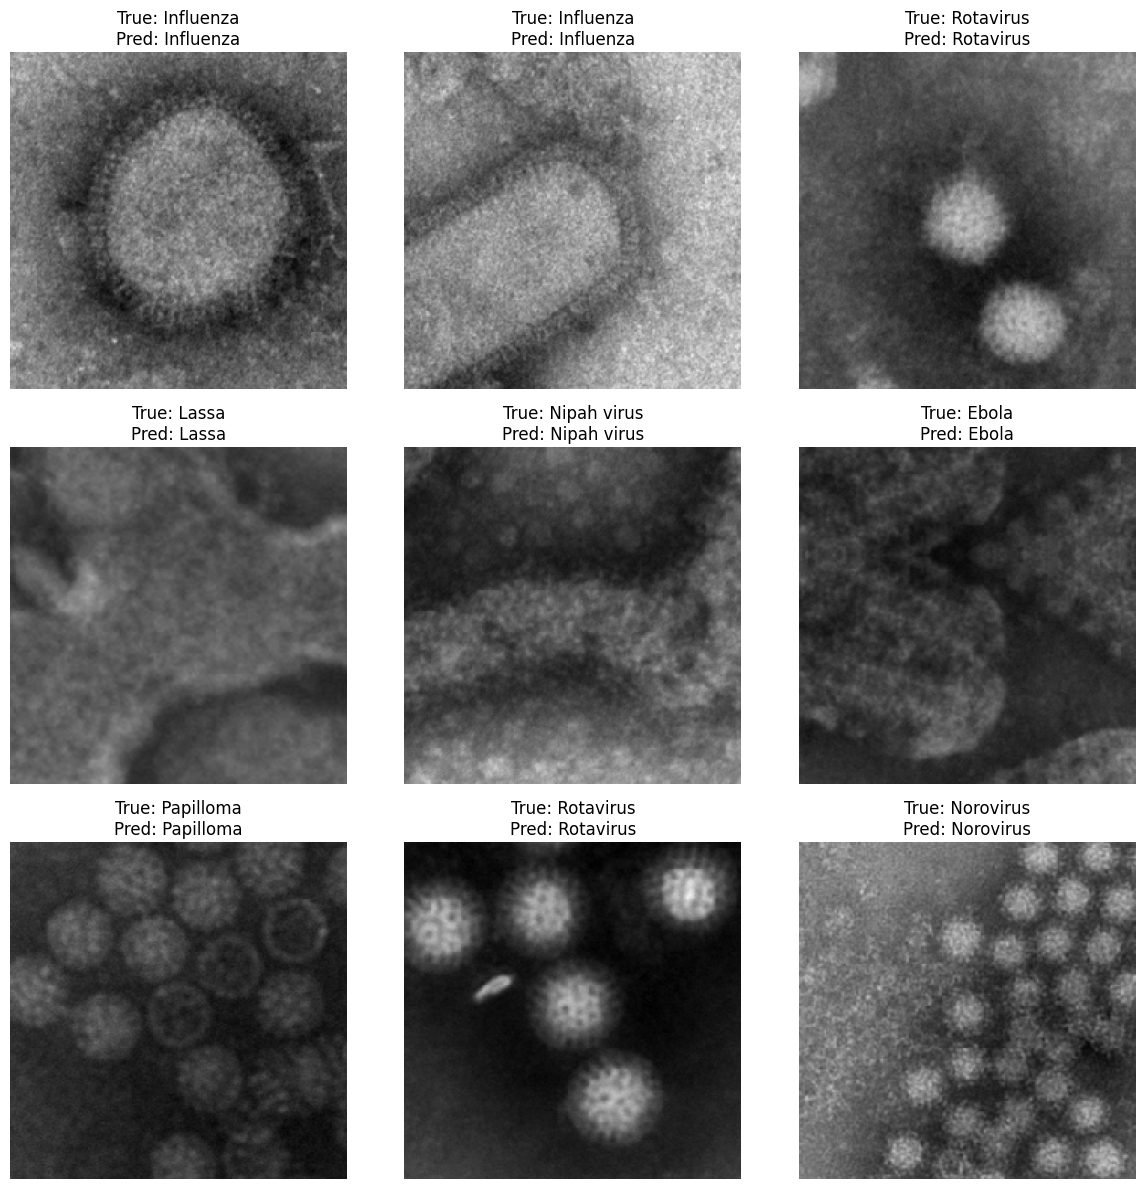

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#  test_generator is your test data generator
test_images, test_labels = next(test_generator)  # Get a batch of test data

# Get the total number of test samples
num_test_samples = len(test_generator.filenames)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# If test_labels is one-hot encoded, convert to class indices
if test_labels.ndim == 2:  # Check if it's one-hot encoded (2D array)
    test_labels = np.argmax(test_labels, axis=1)  # Convert to class indices

# Make predictions on test data
predictions = model.predict(test_images)  # Predictions on test images
pred_classes = np.argmax(predictions, axis=1)  # Get predicted class indices

# Visualize the results
plt.figure(figsize=(12, 12))
for i in range(min(9, num_test_samples)):  # Display up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])

    # Get true and predicted labels
    true_label = class_labels[test_labels[i]]  # True label
    predicted_label = class_labels[pred_classes[i]]  # Predicted label

    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
model.save('my_denes.keras')

In [ ]:
!cp my_denes.keras /content/drive/MyDrive/Model/

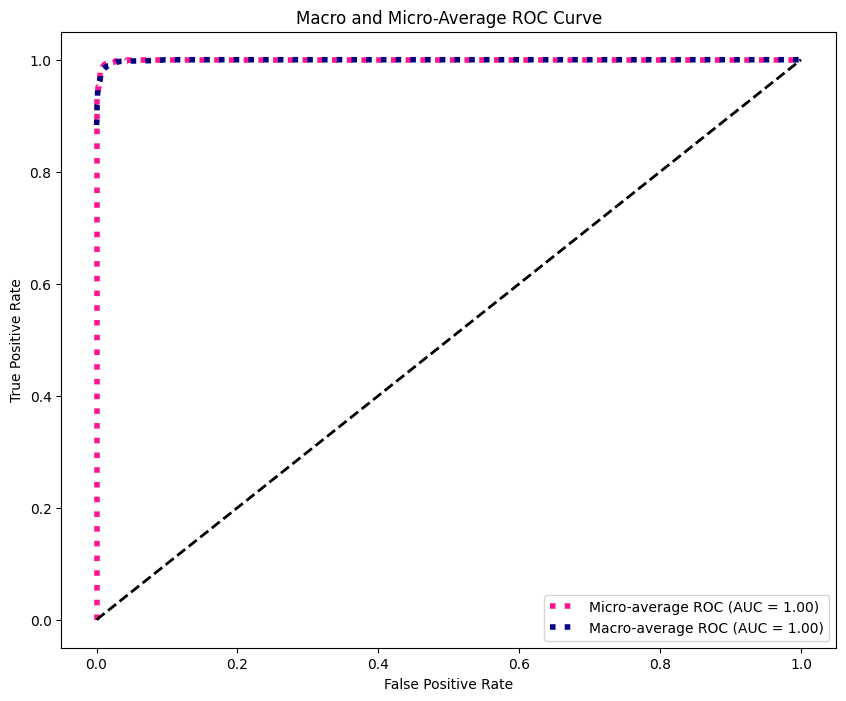

In [ ]:
# Compute macro and micro AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_labels))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_labels)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})", color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})", color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro and Micro-Average ROC Curve')
plt.legend(loc="lower right")
plt.show()
